In [1]:
# import statements
import csv
import pandas as pd
import numpy as np
import re
import string
import time
import math

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils import class_weight
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
df = pd.read_csv('train_values.csv')
lbl = pd.read_csv('train_labels.csv')
tdf = pd.read_csv('test_values.csv')
df_l = pd.merge(df,lbl,on='building_id',how='inner')

In [3]:
df.sample(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
200492,20489,7,617,4566,2,30,11,5,t,r,...,0,0,0,0,0,0,0,0,0,0
4969,383631,6,1181,3301,3,20,9,7,t,r,...,0,0,0,0,0,0,0,0,0,0
177995,455699,17,1308,9358,2,5,8,7,t,r,...,0,0,0,0,0,0,0,0,0,0
102745,615213,19,522,2272,2,15,5,5,t,r,...,0,0,0,0,0,0,0,0,0,0
15455,412777,4,616,10328,2,30,6,4,t,r,...,0,0,0,0,0,0,0,0,0,0
224758,57750,21,581,7218,3,10,5,7,t,r,...,0,0,0,0,0,0,0,0,0,0
173528,923446,22,1320,11775,2,25,3,4,t,u,...,0,1,0,0,0,0,0,0,0,0
151603,180965,13,909,9341,2,45,5,4,n,r,...,0,0,0,0,0,0,0,0,0,0
194146,942455,7,904,6928,2,20,1,5,t,r,...,1,0,0,0,0,0,0,0,0,0
165824,216757,17,566,8116,1,5,6,3,t,i,...,0,0,0,0,0,0,0,0,0,0


# There are no nulls in the data

In [4]:
df_l.isnull().sum()

building_id                               0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber                 0
has_superstructure_bamboo       

# There are 38 columns in original data out of which 8 has categorical values,8 has integer values and 22 columns has binary values(0/1)

In [5]:
print(len(df.columns[1:]))
cat_col = df.loc[:,df.dtypes=='object'].columns.tolist()
int_col = list(df.columns[1:8])
int_col.append('count_families')
total_col = list(df.columns[1:])
bin_col = [col for col in total_col if col not in (int_col+cat_col)]
print(len(cat_col))
print(len(int_col))
print(len(bin_col))

38
8
8
22


# EDA on int_col
['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families']

In [6]:
df_l[int_col]

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,count_families
0,6,487,12198,2,30,6,5,1
1,8,900,2812,2,10,8,7,1
2,21,363,8973,2,10,5,5,1
3,22,418,10694,2,10,6,5,1
4,11,131,1488,3,30,8,9,1
...,...,...,...,...,...,...,...,...
260596,25,1335,1621,1,55,6,3,1
260597,17,715,2060,2,0,6,5,1
260598,17,51,8163,3,55,6,7,1
260599,26,39,1851,2,10,14,6,1


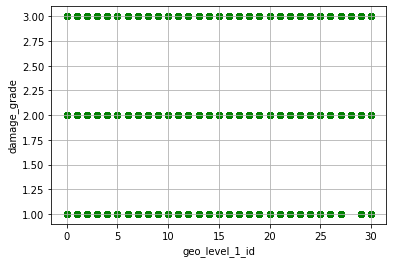

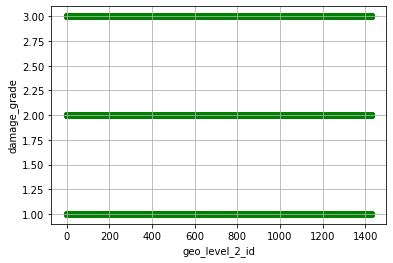

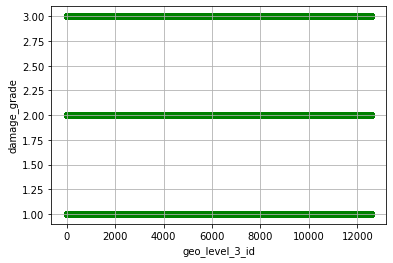

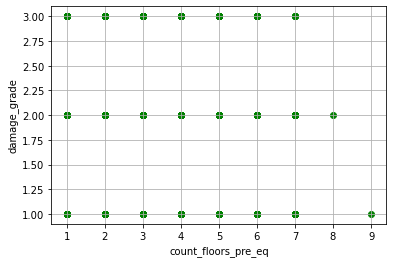

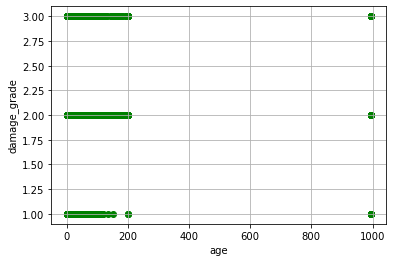

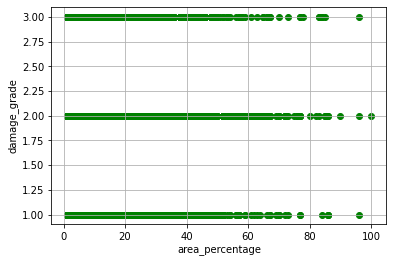

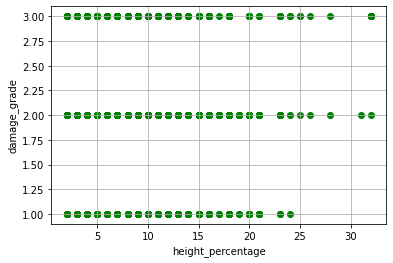

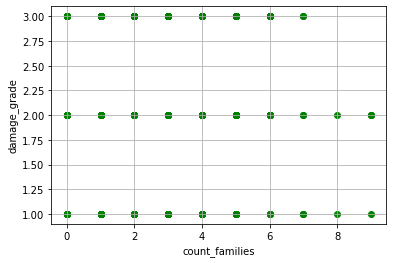

In [7]:
# plotting of the integer columns wrt taget variable
for col in int_col:
    plt.scatter(x=df_l[col],y=df_l['damage_grade'],color='g')
    plt.ylabel('damage_grade')
    plt.xlabel(col)
    plt.grid()
    plt.show()


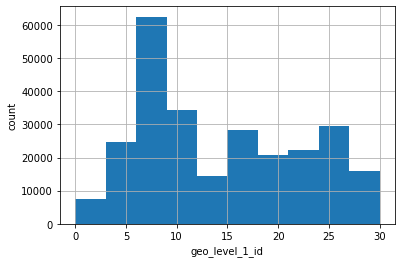

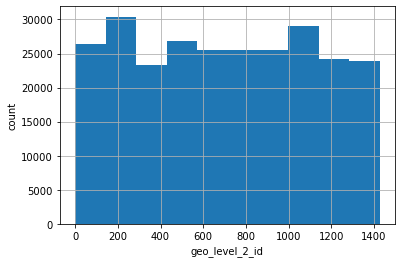

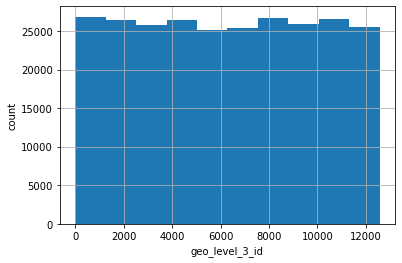

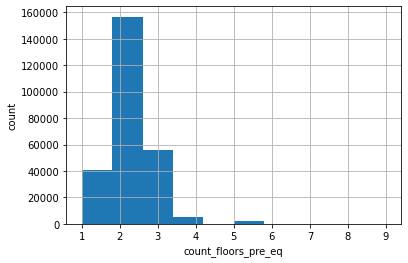

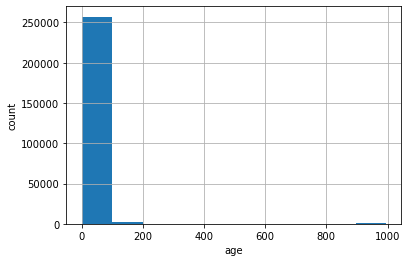

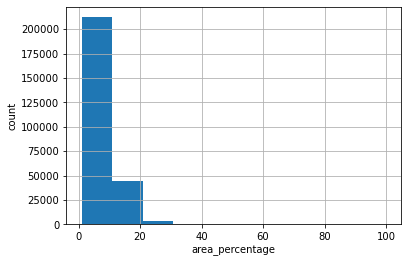

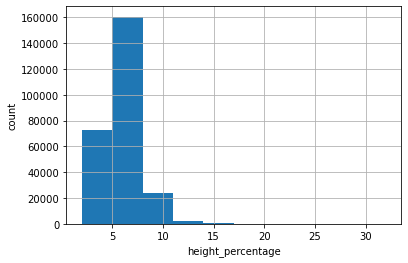

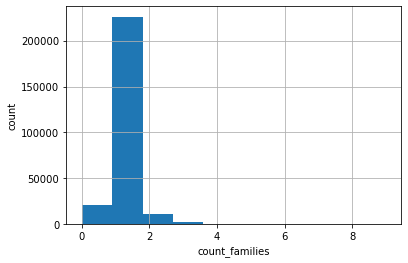

In [8]:
for col in int_col:
    plt.hist(df_l[col])
    plt.ylabel('count')
    plt.xlabel(col)
    plt.grid()
    plt.show()

In [9]:
for col in int_col:
    print(df_l[col].value_counts().describe())
    print('===================================')

count       31.000000
mean      8406.483871
std       7922.972472
min        265.000000
25%       2503.000000
50%       4332.000000
75%      14728.500000
max      24381.000000
Name: geo_level_1_id, dtype: float64
count    1414.000000
mean      184.300566
std       259.928137
min         1.000000
25%        27.000000
50%       120.500000
75%       256.000000
max      4038.000000
Name: geo_level_2_id, dtype: float64
count    11595.000000
mean        22.475291
std         29.507407
min          1.000000
25%          5.000000
50%         14.000000
75%         30.000000
max        651.000000
Name: geo_level_3_id, dtype: float64
count         9.000000
mean      28955.666667
std       52139.384234
min           1.000000
25%          39.000000
50%        2246.000000
75%       40441.000000
max      156623.000000
Name: count_floors_pre_eq, dtype: float64
count       42.000000
mean      6204.785714
std      11369.183995
min          1.000000
25%          7.500000
50%        463.000000
75%       4

# box plot

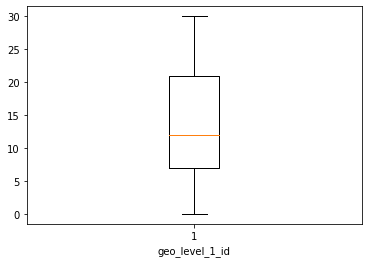

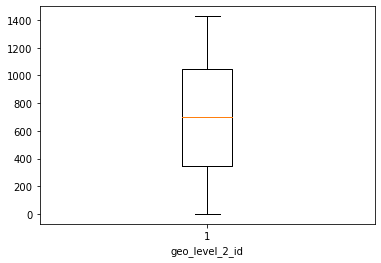

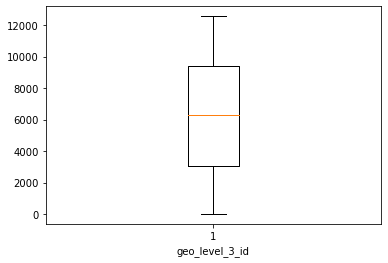

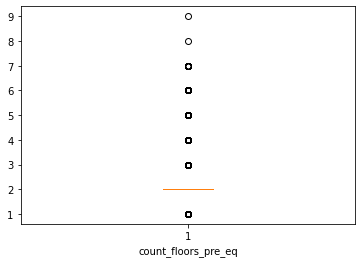

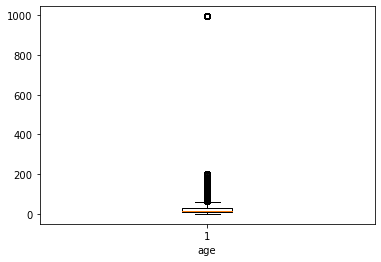

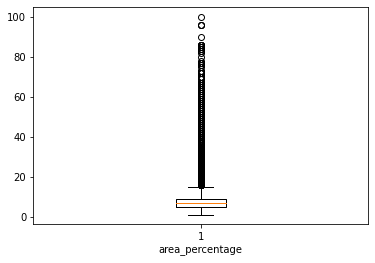

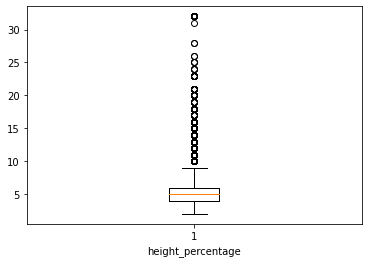

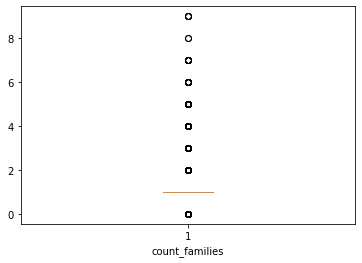

In [10]:
for col in int_col:
    plt.boxplot(df_l[col])
    plt.xlabel(col)
    plt.show()

In [11]:
z = df_l[int_col].describe().T
for col in int_col:
    q1 = df_l[col].quantile(0.25)
    q3 = df_l[col].quantile(0.75)
    IQR = q3-q1
    outlier_limit = q3+1.5*IQR
    z.loc[col,'outlier_limit'] = outlier_limit
    z.loc[col,'outlier_count'] = len(df_l.loc[df_l[col]>outlier_limit])
    z.loc[col,'outlier_percentage']=(z.loc[col,'outlier_count']/z.loc[col,'count'])*100
    temp = df_l[col]
    m  = df_l[col].mean()
    s = df_l[col].std()
    z_lim = 3*s+m
    val = (temp>z_lim).sum()
    z.loc[col,'z_limit'] =z_lim
    z.loc[col,'z_outlier_count']=val
z
    

,count,mean,std,min,25%,50%,75%,max,outlier_limit,outlier_count,outlier_percentage,z_limit,z_outlier_count
geo_level_1_id,260601.0,13.900353,8.033617,0.0,7.0,12.0,21.0,30.0,42.0,0.0,0.000000,38.001203,0.0
geo_level_2_id,260601.0,701.074685,412.710734,0.0,350.0,702.0,1050.0,1427.0,2100.0,0.0,0.000000,1939.206886,0.0
geo_level_3_id,260601.0,6257.876148,3646.369645,0.0,3073.0,6270.0,9412.0,12567.0,18920.5,0.0,0.000000,17196.985082,0.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0,2.0,63537.0,24.380950,4.312717,2496.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0,60.0,12499.0,4.796221,247.232838,1390.0
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0,15.0,13557.0,5.202206,21.194743,3845.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0,9.0,7843.0,3.009582,11.189620,2434.0
count_families,260601.0,0.983949,0.418389,0.0,1.0,1.0,1.0,9.0,1.0,13624.0,5.227915,2.239116,2330.0


In [12]:
df_l[int_col].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   geo_level_1_id       260601 non-null  int64
 1   geo_level_2_id       260601 non-null  int64
 2   geo_level_3_id       260601 non-null  int64
 3   count_floors_pre_eq  260601 non-null  int64
 4   age                  260601 non-null  int64
 5   area_percentage      260601 non-null  int64
 6   height_percentage    260601 non-null  int64
 7   count_families       260601 non-null  int64
dtypes: int64(8)
memory usage: 17.9 MB


# EDA on cat_col
['land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'legal_ownership_status']

In [13]:
df_l[cat_col].describe(include=['object']).T

,count,unique,top,freq
land_surface_condition,260601,3,t,216757
foundation_type,260601,5,r,219196
roof_type,260601,3,n,182842
ground_floor_type,260601,5,f,209619
other_floor_type,260601,4,q,165282
position,260601,4,s,202090
plan_configuration,260601,10,d,250072
legal_ownership_status,260601,4,v,250939


In [14]:
for col in cat_col:
    print(df_l[col].value_counts())
    print(df_l[col].value_counts().describe())

t    216757
n     35528
o      8316
Name: land_surface_condition, dtype: int64
count         3.000000
mean      86867.000000
std      113307.909305
min        8316.000000
25%       21922.000000
50%       35528.000000
75%      126142.500000
max      216757.000000
Name: land_surface_condition, dtype: float64
r    219196
w     15118
u     14260
i     10579
h      1448
Name: foundation_type, dtype: int64
count         5.000000
mean      52120.200000
std       93555.095592
min        1448.000000
25%       10579.000000
50%       14260.000000
75%       15118.000000
max      219196.000000
Name: foundation_type, dtype: float64
n    182842
q     61576
x     16183
Name: roof_type, dtype: int64
count         3.000000
mean      86867.000000
std       86159.918646
min       16183.000000
25%       38879.500000
50%       61576.000000
75%      122209.000000
max      182842.000000
Name: roof_type, dtype: float64
f    209619
x     24877
v     24593
z      1004
m       508
Name: ground_floor_type, dtype: 

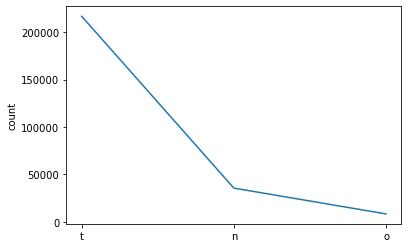

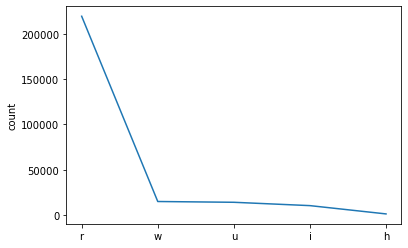

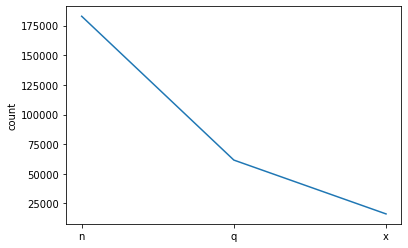

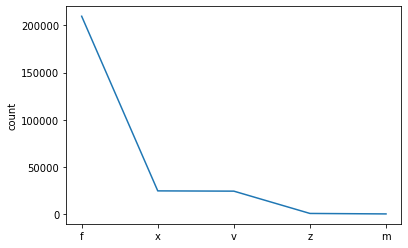

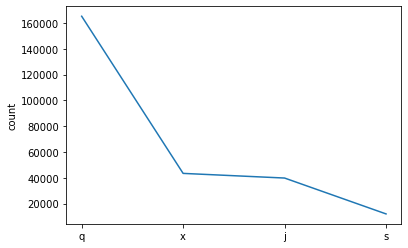

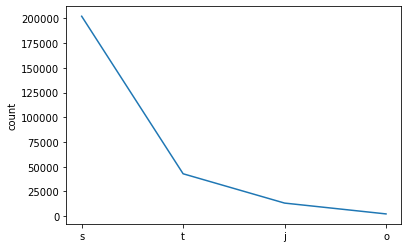

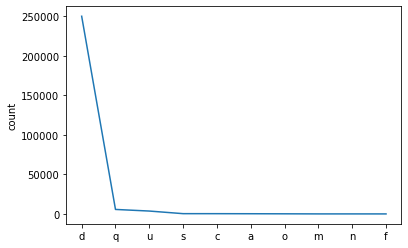

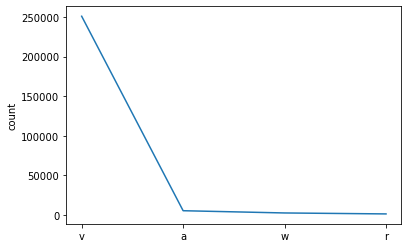

In [15]:
for col in cat_col:
    plt.plot(df_l[col].value_counts())
    plt.ylabel('count')
    plt.show()

In [16]:
df_l['building_id'].nunique()==df.shape[0]

True

In [17]:
for col in cat_col:
    print(pd.crosstab(df_l[col],df_l['damage_grade'],margins=True))
    print("------------------------------------------------------")

damage_grade                1       2      3     All
land_surface_condition                              
n                        2556   21484  11488   35528
o                         602    4708   3006    8316
t                       21966  122067  72724  216757
All                     25124  148259  87218  260601
------------------------------------------------------
damage_grade         1       2      3     All
foundation_type                              
h                  358     579    511    1448
i                 6004    4354    221   10579
r                10720  125515  82961  219196
u                 3689    8541   2030   14260
w                 4353    9270   1495   15118
All              25124  148259  87218  260601
------------------------------------------------------
damage_grade      1       2      3     All
roof_type                                 
n             13547  106447  62848  182842
q              3926   34009  23641   61576
x              7651    7803    7

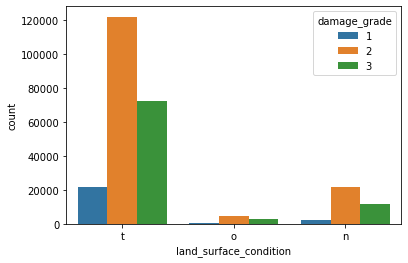

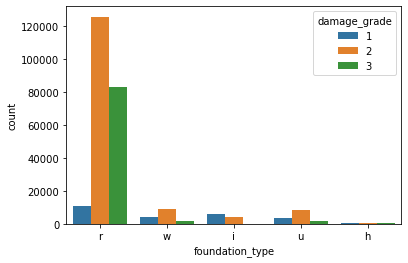

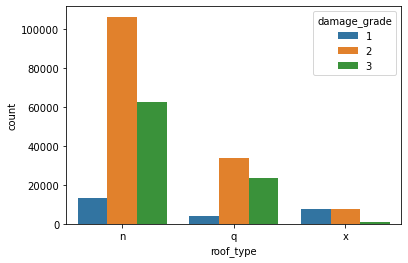

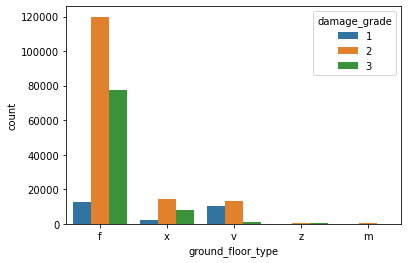

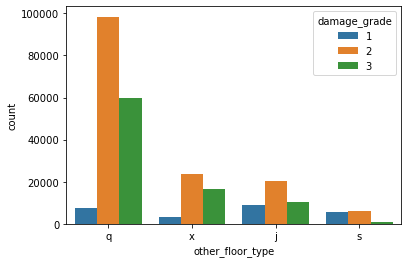

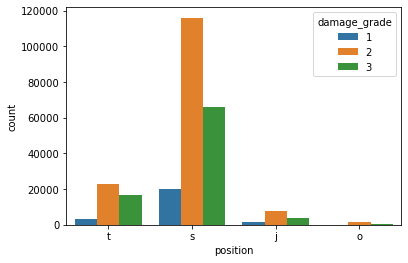

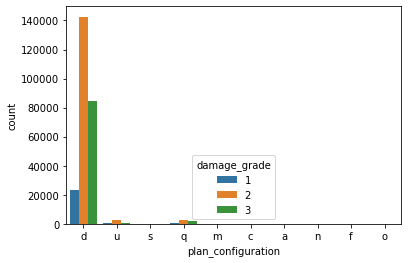

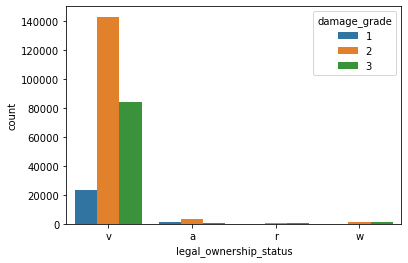

In [18]:
for col in cat_col:
    sns.countplot(x=col ,hue="damage_grade", data=df_l)
    plt.show()

# ETA on binary columns
['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [19]:
for col in bin_col:
    print(df_l[col].value_counts())

0    237500
1     23101
Name: has_superstructure_adobe_mud, dtype: int64
1    198561
0     62040
Name: has_superstructure_mud_mortar_stone, dtype: int64
0    251654
1      8947
Name: has_superstructure_stone_flag, dtype: int64
0    255849
1      4752
Name: has_superstructure_cement_mortar_stone, dtype: int64
0    242840
1     17761
Name: has_superstructure_mud_mortar_brick, dtype: int64
0    240986
1     19615
Name: has_superstructure_cement_mortar_brick, dtype: int64
0    194151
1     66450
Name: has_superstructure_timber, dtype: int64
0    238447
1     22154
Name: has_superstructure_bamboo, dtype: int64
0    249502
1     11099
Name: has_superstructure_rc_non_engineered, dtype: int64
0    256468
1      4133
Name: has_superstructure_rc_engineered, dtype: int64
0    256696
1      3905
Name: has_superstructure_other, dtype: int64
0    231445
1     29156
Name: has_secondary_use, dtype: int64
0    243824
1     16777
Name: has_secondary_use_agriculture, dtype: int64
0    251838
1      8763


In [20]:
for col in bin_col:
    print(pd.crosstab(df_l[col],df_l['damage_grade'],normalize=True,margins=True))

damage_grade                         1         2        3       All
has_superstructure_adobe_mud                                       
0                             0.094129  0.515566  0.30166  0.911355
1                             0.002279  0.053346  0.03302  0.088645
All                           0.096408  0.568912  0.33468  1.000000
damage_grade                                1         2         3       All
has_superstructure_mud_mortar_stone                                        
0                                    0.062793  0.131665  0.043607  0.238065
1                                    0.033615  0.437247  0.291073  0.761935
All                                  0.096408  0.568912  0.334680  1.000000
damage_grade                          1         2         3       All
has_superstructure_stone_flag                                        
0                              0.095710  0.551514  0.318445  0.965668
1                              0.000698  0.017398  0.016236  0.034332


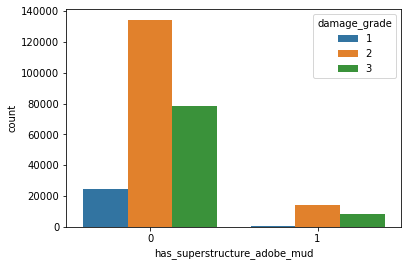

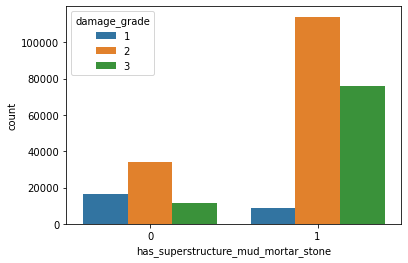

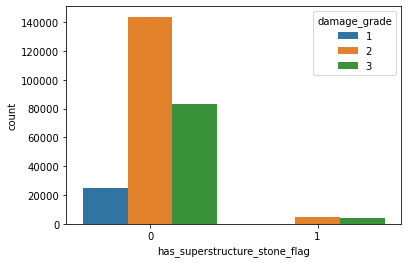

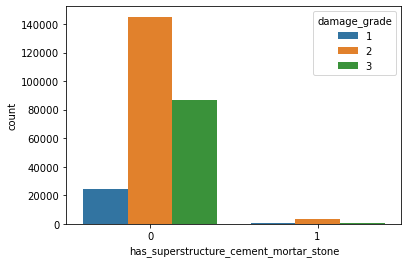

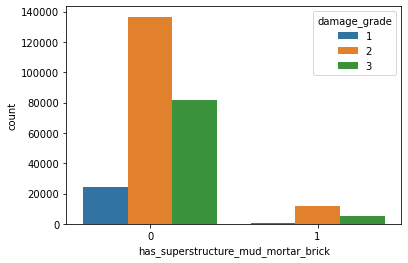

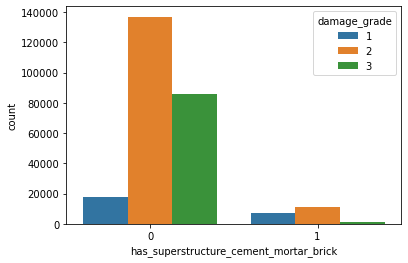

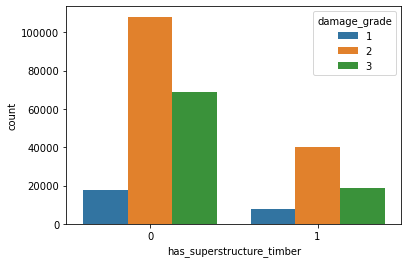

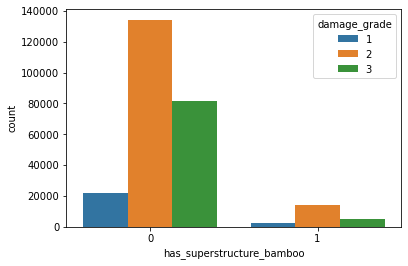

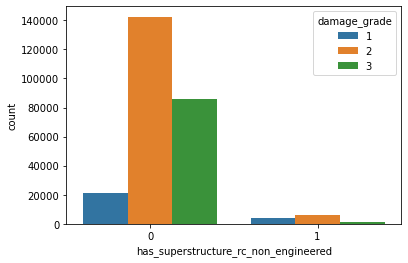

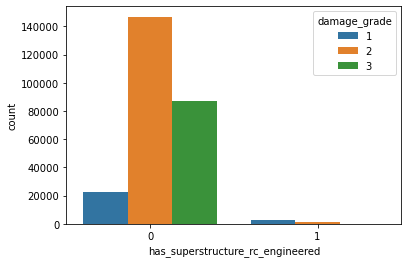

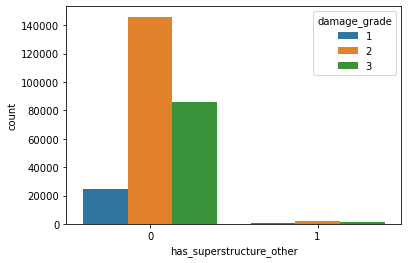

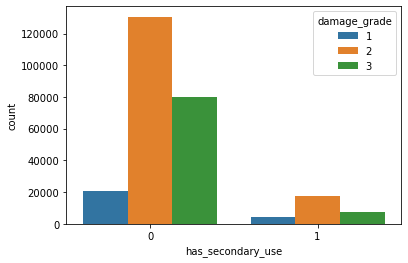

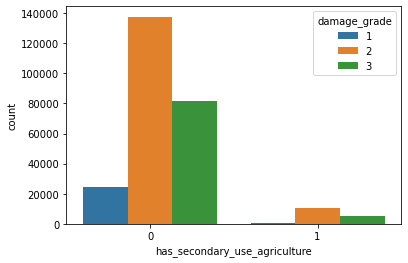

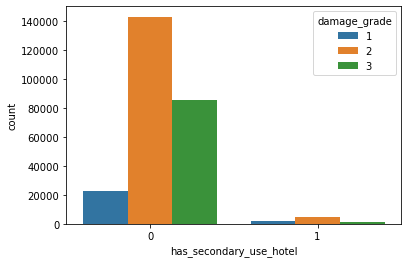

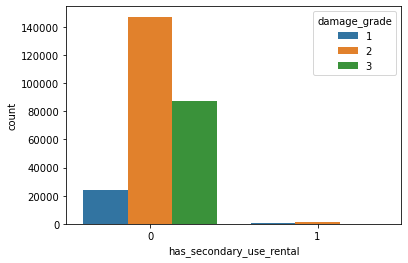

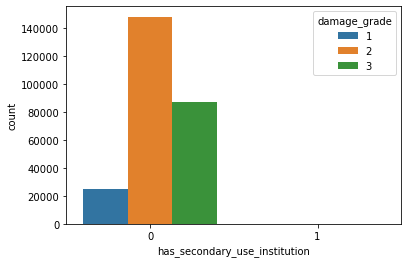

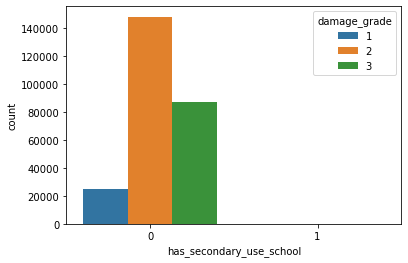

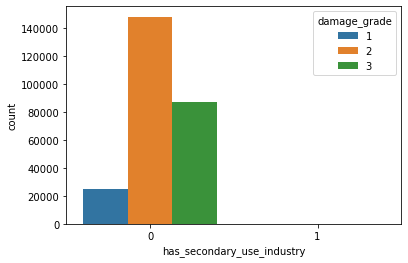

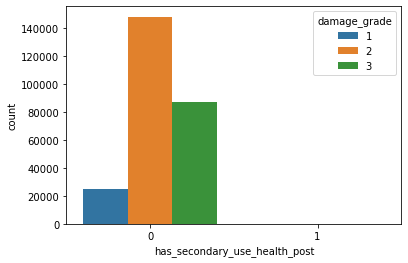

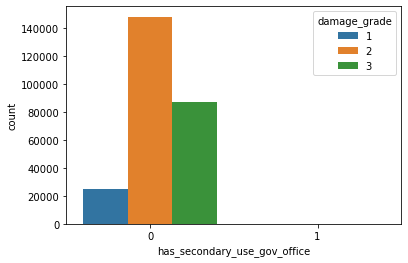

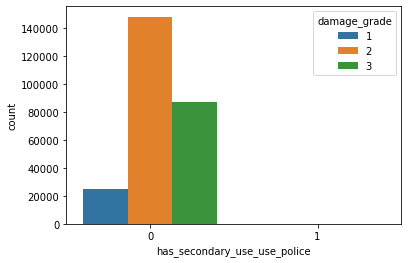

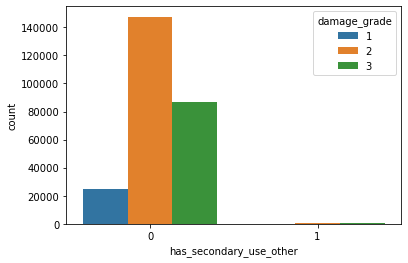

In [21]:
for col in bin_col:
    sns.countplot(x=col,hue='damage_grade',data=df_l)
    plt.show()

# No difference of categorical values in test and train

In [22]:
for col in cat_col:
    print(len(set(tdf[col]).difference(set(df_l[col]))))

0
0
0
0
0
0
0
0


# creating dummies varibale  for categorical columns

In [23]:
total_df = pd.concat([df,tdf],axis=0)
dumm = pd.get_dummies(total_df[cat_col])
total_df = pd.concat([total_df,dumm],axis=1)
total_df.drop(cat_col,axis=1,inplace=True)
train_df = total_df[:len(df_l)]
test_df = total_df[len(df_l):]

In [24]:
train_df = pd.merge(train_df,lbl,on='building_id',how='inner')
train_df.shape

(260601, 70)

In [25]:
train_df['damage_grade'].value_counts(normalize=1)

2    0.568912
3    0.334680
1    0.096408
Name: damage_grade, dtype: float64

# Checking the multi collinearity between the input features using variance inflation factor

In [26]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)
calc_vif(train_df[int_col])

,variables,VIF
0,geo_level_1_id,3.502543
1,geo_level_2_id,3.450101
2,geo_level_3_id,3.460647
3,count_floors_pre_eq,22.855294
4,age,1.138410
5,area_percentage,4.365464
6,height_percentage,22.819052
7,count_families,5.660185


In [27]:
corr_df=train_df[int_col]  #New dataframe to calculate correlation between numeric features
cor= corr_df.corr(method='pearson')
print(cor)

                     geo_level_1_id  geo_level_2_id  geo_level_3_id  \
geo_level_1_id             1.000000       -0.061405        0.002718   
geo_level_2_id            -0.061405        1.000000        0.000921   
geo_level_3_id             0.002718        0.000921        1.000000   
count_floors_pre_eq       -0.089364        0.047730       -0.021646   
age                       -0.003908        0.012594       -0.006385   
area_percentage            0.071158       -0.049443       -0.005643   
height_percentage         -0.063474        0.035516       -0.024507   
count_families             0.035108       -0.012439       -0.002479   

                     count_floors_pre_eq       age  area_percentage  \
geo_level_1_id                 -0.089364 -0.003908         0.071158   
geo_level_2_id                  0.047730  0.012594        -0.049443   
geo_level_3_id                 -0.021646 -0.006385        -0.005643   
count_floors_pre_eq             1.000000  0.086668         0.101071   
age  

<ipython-input-28-fc8cf9c3aff7>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


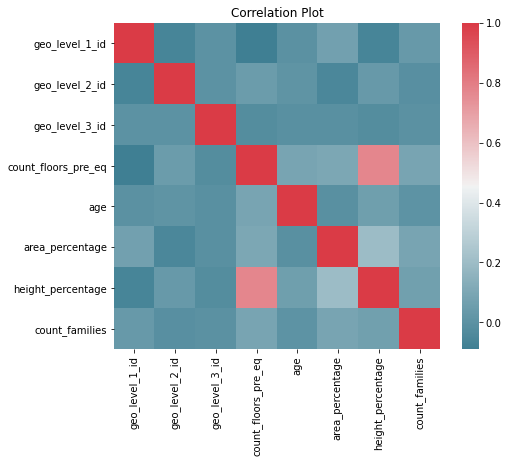

In [28]:
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

# conclusion except the height_percentage feature and count_floors_per_eq no other columns are co related